Uhh yea so I stole this notebook off kaggle and repurposed it to test whether we can apply the superposition and interference theory to a real dataset like MNIST. I read the assignment specs again, and I think we should probably try to 'propose something new' to maybe get more marks, instead of only reproducing their results and showing how interference can create false positives/negatives for features. The 'something new' I'm testing is an activation function that might be better at mitigating interference compared to relu. You know how the paper states that when applying relu as the non-linearity, negative interference essentially becomes 'free' for the model because negative activations get cut off anyways? What if we set the cut-off point to be some small positive value instead of at 0? Wouldn't that also give it the additional capability of mitigating some small positive interferences and thus improve the model's ability to hold more superpositions without the cost associated with it? By training an autoencoder on MNIST, we can actually see that such an activation function converges to a lower loss than an otherwise identical network with relu activation.


# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='https://reyhaneaskari.github.io/Reyhane%20Askari_files/ae.png'/>

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!



In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor

#### NOTE: I've added some transforms here to increase the sparsity of the features.
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((56, 56)),
    transforms.RandomAffine(degrees=0, translate=(0.4, 0.4), scale=(0.3, 0.3))
    ])

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


train_data, val_data = torch.utils.data.random_split(train_data, (0.9, 0.1))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

(1, 28, 28)


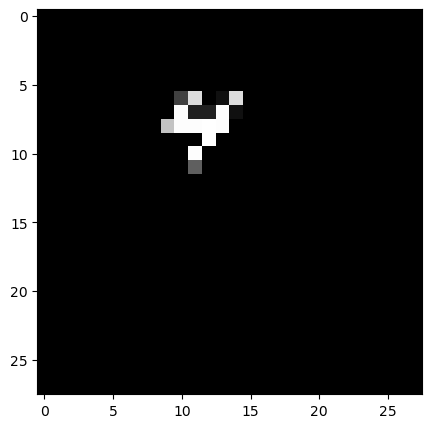

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
print(images[0].shape)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='https://theaisummer.com/static/25f603171034d2fc8f6a518b8537f85a/ee604/vae.png' width=70% />


#### Build the graph for the autoencoder in the cell below. 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

**The compressed representation should be a vector with dimension `encoding_dim=32`.**

In [4]:
def erelu(inp, threshold, multi=0.05):
    mask = inp >= threshold
    mask = mask + multi
    return inp * mask

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, in_dim, encoding_dim, threshold=0.0):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Linear(in_dim, encoding_dim)
        ## decoder ##
        self.decoder = nn.Linear(encoding_dim, in_dim)
        self.threshold = threshold

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = self.encoder(x)
        # pass out into decoder
        out = erelu(self.decoder(out), self.threshold)
        
        return out

# initialize the NN
encoding_dim = 32
model = Autoencoder(28 ** 2, encoding_dim)
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [12]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# number of epochs to train the model
n_epochs = 20

def train():
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        val_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
                
        # print avg training statistics 
        with torch.no_grad():
            for data in val_loader:
                images, _ = data 
                # flatten images
                images = images.view(images.size(0), -1)
                # forward pass: compute predicted outputs by passing inputs to the model
                outputs = model(images)
                # calculate the loss
                loss = criterion(outputs, images)
                # update running training loss
                val_loss += loss.item()*images.size(0)
                
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}, Validation loss: {:.6f}'.format(
            epoch, 
            train_loss,
            val_loss
            ))

In [14]:
train()

Epoch: 1 	Training Loss: 0.089104, Validation loss: 0.067308
Epoch: 2 	Training Loss: 0.064583, Validation loss: 0.063285
Epoch: 3 	Training Loss: 0.062009, Validation loss: 0.061820
Epoch: 4 	Training Loss: 0.060799, Validation loss: 0.060429
Epoch: 5 	Training Loss: 0.060029, Validation loss: 0.060269
Epoch: 6 	Training Loss: 0.059453, Validation loss: 0.059701
Epoch: 7 	Training Loss: 0.059149, Validation loss: 0.059190
Epoch: 8 	Training Loss: 0.058863, Validation loss: 0.059532
Epoch: 9 	Training Loss: 0.058606, Validation loss: 0.058837
Epoch: 10 	Training Loss: 0.058442, Validation loss: 0.058696
Epoch: 11 	Training Loss: 0.058221, Validation loss: 0.058379
Epoch: 12 	Training Loss: 0.058010, Validation loss: 0.058159
Epoch: 13 	Training Loss: 0.058006, Validation loss: 0.058308
Epoch: 14 	Training Loss: 0.057979, Validation loss: 0.058279
Epoch: 15 	Training Loss: 0.057761, Validation loss: 0.058247
Epoch: 16 	Training Loss: 0.057586, Validation loss: 0.058015
Epoch: 17 	Traini

In [15]:
model = Autoencoder(28 ** 2, encoding_dim, threshold=0.3)

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train()


Epoch: 1 	Training Loss: 0.092099, Validation loss: 0.062916
Epoch: 2 	Training Loss: 0.058663, Validation loss: 0.056899
Epoch: 3 	Training Loss: 0.054914, Validation loss: 0.054209
Epoch: 4 	Training Loss: 0.053341, Validation loss: 0.053519
Epoch: 5 	Training Loss: 0.052565, Validation loss: 0.052707
Epoch: 6 	Training Loss: 0.051748, Validation loss: 0.051942
Epoch: 7 	Training Loss: 0.051331, Validation loss: 0.050990
Epoch: 8 	Training Loss: 0.051010, Validation loss: 0.051164
Epoch: 9 	Training Loss: 0.050505, Validation loss: 0.050539
Epoch: 10 	Training Loss: 0.050447, Validation loss: 0.051080
Epoch: 11 	Training Loss: 0.050103, Validation loss: 0.051115
Epoch: 12 	Training Loss: 0.049955, Validation loss: 0.049860
Epoch: 13 	Training Loss: 0.049848, Validation loss: 0.049807
Epoch: 14 	Training Loss: 0.049720, Validation loss: 0.050051
Epoch: 15 	Training Loss: 0.049656, Validation loss: 0.048925
Epoch: 16 	Training Loss: 0.049277, Validation loss: 0.049698
Epoch: 17 	Traini

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

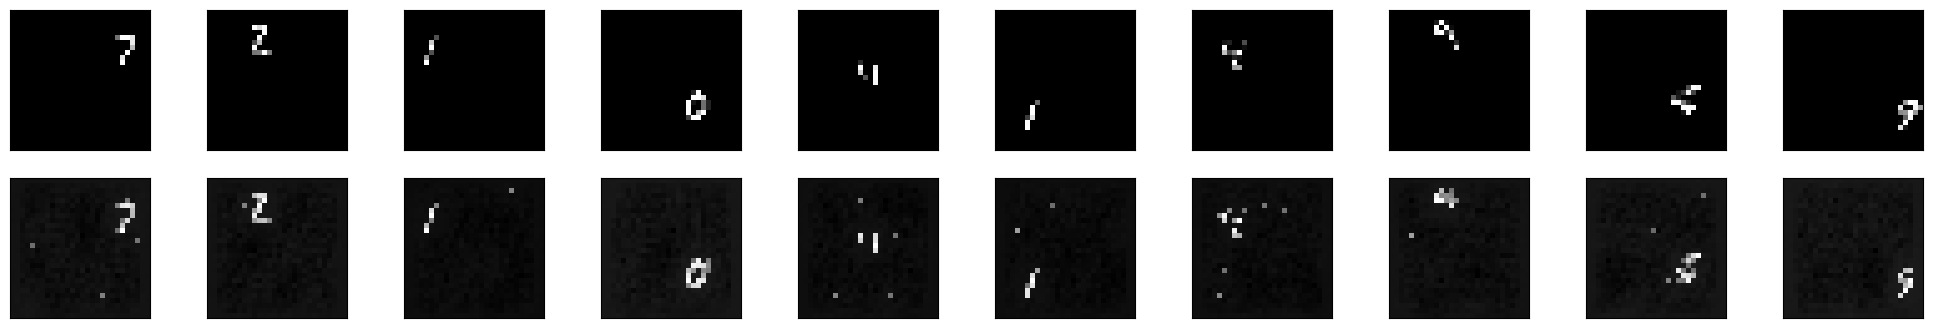

In [56]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.